# Исследование надежности заемщиков

## Описание проекта
<p>Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.</p>
<p>Результаты исследования будут учтены при построении модели кредитного скоринга — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.</p>

### Описание данных<br>
* `children` — количество детей в семье
* `days_employed` — общий трудовой стаж в днях
* `dob_years` — возраст клиента в годах
* `education` — уровень образования клиента
* `education_id` — идентификатор уровня образования
* `family_status` — семейное положение
* `family_status_id` — идентификатор семейного положения
* `gender` — пол клиента
* `income_type` — тип занятости
* `debt` — имел ли задолженность по возврату кредитов
* `total_income` — ежемесячный доход
* `purpose` — цель получения кредита

## Считаем информацию и изучим общую информацию о данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


pd.options.display.float_format ='{:,.2f}'.format

data = pd.read_csv('data/data.csv')

**Выведим первые 10 строчек**

In [2]:
data.head(10)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,"-8,437.67",42,высшее,0,женат / замужем,0,F,сотрудник,0,"253,875.64",покупка жилья
1,1,"-4,024.80",36,среднее,1,женат / замужем,0,F,сотрудник,0,"112,080.01",приобретение автомобиля
2,0,"-5,623.42",33,Среднее,1,женат / замужем,0,M,сотрудник,0,"145,885.95",покупка жилья
3,3,"-4,124.75",32,среднее,1,женат / замужем,0,M,сотрудник,0,"267,628.55",дополнительное образование
4,0,"340,266.07",53,среднее,1,гражданский брак,1,F,пенсионер,0,"158,616.08",сыграть свадьбу
5,0,-926.19,27,высшее,0,гражданский брак,1,M,компаньон,0,"255,763.57",покупка жилья
6,0,"-2,879.20",43,высшее,0,женат / замужем,0,F,компаньон,0,"240,525.97",операции с жильем
7,0,-152.78,50,СРЕДНЕЕ,1,женат / замужем,0,M,сотрудник,0,"135,823.93",образование
8,2,"-6,929.87",35,ВЫСШЕЕ,0,гражданский брак,1,F,сотрудник,0,"95,856.83",на проведение свадьбы
9,0,"-2,188.76",41,среднее,1,женат / замужем,0,M,сотрудник,0,"144,425.94",покупка жилья для семьи


**В колонке `days_employed` есть отрицательные значения, а в колонке `education` одинаковые категории записаны в разном регистре, давайте сразу исправим это**

In [3]:
data['days_employed'] = data['days_employed'].abs()
data['education'] = data['education'].str.lower()

**Посмотрим общую информацию о датафрейме**

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


**У нас есть пропущенные значения, посмотрим сколько их**

In [5]:
data.isna().sum()

children               0
days_employed       2174
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64

## Предобработка данных

### Удаление пропусков

Столбец `total_income`, хранящий данные о доходах, содержит в себе пропущенные значения. На сумму дохода сильнее всего влияет тип занятости, поэтому заполнить пропуски в этом столбце нужно медианным значением по каждому типу из столбца `income_type`.

Посмотрим медианные значения по каждому типу занятости

In [6]:
data.groupby('income_type').total_income.median()

income_type
безработный       131,339.75
в декрете          53,829.13
госслужащий       150,447.94
компаньон         172,357.95
пенсионер         118,514.49
предприниматель   499,163.14
сотрудник         142,594.40
студент            98,201.63
Name: total_income, dtype: float64

Странно что у безрабтных доход выше чем у пенсионеров

**Посмотрим сколько наблюдений в каждой категории**

In [7]:
income_type_cat = data.groupby('income_type').income_type.count().sort_values(ascending=False)
income_type_cat

income_type
сотрудник          11119
компаньон           5085
пенсионер           3856
госслужащий         1459
безработный            2
предприниматель        2
в декрете              1
студент                1
Name: income_type, dtype: int64

**Есть малочисленные категории, которые для нас не несут никакой информации, удалим их**

In [8]:
data = data[~data.income_type.isin(income_type_cat.index[4:])]

**Заполним пропуски медианными значениями**

In [9]:
median_income = data.groupby('income_type').total_income.transform('median')
data.total_income.fillna(median_income, inplace=True)

**Заполним пропуски в столбце `days_employed` медианными значениями по каждому типу занятости `income_type`.**

Посмотрим медианные значения по каждому типу занятости

In [10]:
data.groupby('income_type').days_employed.median()

income_type
госслужащий     2,689.37
компаньон       1,547.38
пенсионер     365,213.31
сотрудник       1,574.20
Name: days_employed, dtype: float64

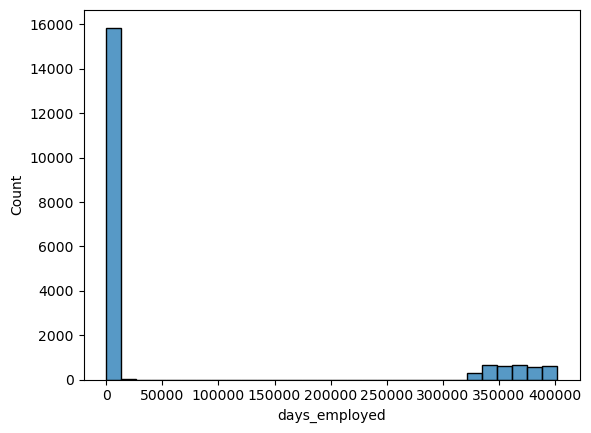

In [11]:
sns.histplot(data.days_employed, bins=30)
plt.show()

У нас есть аномальные значения, надо это исправить.

**Аномальные значение заполним `None`**

In [12]:
data.loc[data.days_employed > 300_000, 'days_employed'] = None

**Посмотрим распределение возраста**

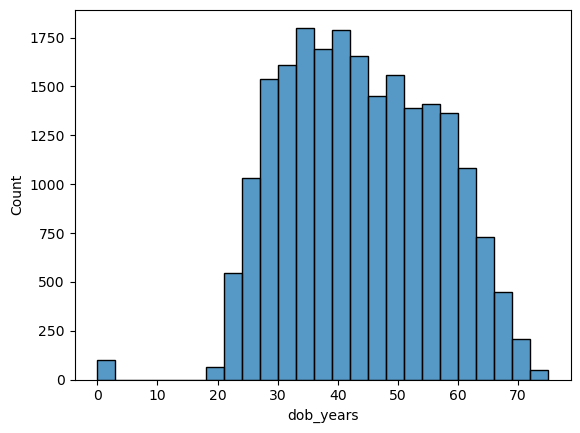

In [13]:
sns.histplot(data.dob_years, bins=25)
plt.show()

In [14]:
data[data.dob_years == 0].shape[0]

101

**Есть наблюдения с возрастом 0, удалим их**

In [15]:
data = data[data.dob_years != 0]

**Создадим новый столбец - `age_cat`**

In [16]:
data['age_cat'] = pd.cut(data.dob_years, 6, precision=0)

**Заполним все пропущенные значения медианой по `age_cat`**

In [17]:
days_employed_median = data.groupby('age_cat').days_employed.transform('median')

In [18]:
data.days_employed.fillna(days_employed_median, inplace=True)

In [19]:
data.groupby('income_type').days_employed.median()

income_type
госслужащий   2,421.05
компаньон     1,577.54
пенсионер     2,430.06
сотрудник     1,607.23
Name: days_employed, dtype: float64

### Обработка аномальных значений

**Посмотрим уникалные значения столбца `children`**

In [20]:
data['children'].value_counts()

children
 0     14076
 1      4801
 2      2041
 3       328
 20       75
-1        47
 4        41
 5         9
Name: count, dtype: int64

**У нас есть аномальные значения(-1 и 20), но этих строчек немного — удалим их.**

In [21]:
data = data[~data.children.isin((-1, 20))]
data.children.unique()

array([1, 0, 3, 2, 4, 5], dtype=int64)

Теперь все в порядке

**Убедимся что все пропуски отсутствуют**

In [22]:
data.isna().sum()

children            0
days_employed       0
dob_years           0
education           0
education_id        0
family_status       0
family_status_id    0
gender              0
income_type         0
debt                0
total_income        0
purpose             0
age_cat             0
dtype: int64

### Изменение типов данных

**Заменим вещественный тип данных в столбце `total_income` на целочисленный**

In [23]:
data['total_income'] = data['total_income'].astype(int)

### Категоризация данных

**Создадим в датафрейме `data` столбец `total_income_category`, на основании признака `total_income`, с категориями:**

- 0–80000 — `'Низкий'`;
- 80001–180000 — `'Средний'`;
- 180000 и выше — `'Высокий'`;

In [24]:
def categorize_income(income):
        if 0 <= income <= 80000:
            return 'Низкий'
        elif 80001 <= income <= 180000:
            return 'Средний'
        elif income >= 180001:
            return 'Высокий'

In [25]:
data['total_income_category'] = data['total_income'].apply(categorize_income)

**Выведим на экран перечень уникальных целей взятия кредита из столбца `purpose`**

In [26]:
data['purpose'].unique()

array(['покупка жилья', 'приобретение автомобиля',
       'дополнительное образование', 'сыграть свадьбу',
       'операции с жильем', 'образование', 'на проведение свадьбы',
       'покупка жилья для семьи', 'покупка недвижимости',
       'покупка коммерческой недвижимости', 'покупка жилой недвижимости',
       'строительство собственной недвижимости', 'недвижимость',
       'строительство недвижимости', 'на покупку подержанного автомобиля',
       'на покупку своего автомобиля',
       'операции с коммерческой недвижимостью',
       'строительство жилой недвижимости', 'жилье',
       'операции со своей недвижимостью', 'автомобили',
       'заняться образованием', 'сделка с подержанным автомобилем',
       'получение образования', 'автомобиль', 'свадьба',
       'получение дополнительного образования', 'покупка своего жилья',
       'операции с недвижимостью', 'получение высшего образования',
       'свой автомобиль', 'сделка с автомобилем',
       'профильное образование', 'высшее об

**Создадим функцию, которая на основании данных из столбца `purpose` сформирует новый столбец `purpose_category`, в который войдут следующие категории:**

- `'операции с автомобилем'`,
- `'операции с недвижимостью'`,
- `'проведение свадьбы'`,
- `'получение образования'`.

In [27]:
def categorize_purpose(row):
    try:
        if 'автом' in row:
            return 'операции с автомобилем'
        elif 'жил' in row or 'недвиж' in row:
            return 'операции с недвижимостью'
        elif 'свад' in row:
            return 'проведение свадьбы'
        elif 'образов' in row:
            return 'получение образования'
    except:
        print(f'Предупреждение!!! мы получили неизвестную ранее категорию - {row}')
        return 'нет категории'

In [28]:
data['purpose_category'] = data['purpose'].apply(categorize_purpose)

## Исследование данных

**Посмотрим общую долю задержек по кредитам**

In [29]:
print(f'Процент задержек по кредитам - {data.debt.mean():.2%}')

Процент задержек по кредитам - 8.09%


**Напишем необходимые функции для визуализации**

In [30]:
def bar_plot(data, col_name, *, title='', xlabel='', ylabel='count', target='debt', size=[15, 5]):    
    plt.rcParams['figure.figsize'] = size
    sns.countplot(data=data, x=col_name, hue=target)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()
    
def pivot_table_calc(data, col_name):
    pivot_table = data[[col_name, 'debt']].pivot_table(
                                                         index=col_name, 
                                                         aggfunc=['count', 'sum', 'mean']
                                                         )
    pivot_table.columns = ('Всего кредитополучателей', 
                           'Всего должников', 
                           'Доля должников')
    display(pivot_table.style.format("{:.2%}", subset=['Доля должников']).background_gradient(cmap='Reds',subset=['Доля должников'] , axis=0))

#### Есть ли зависимость между количеством детей и возвратом кредита в срок?

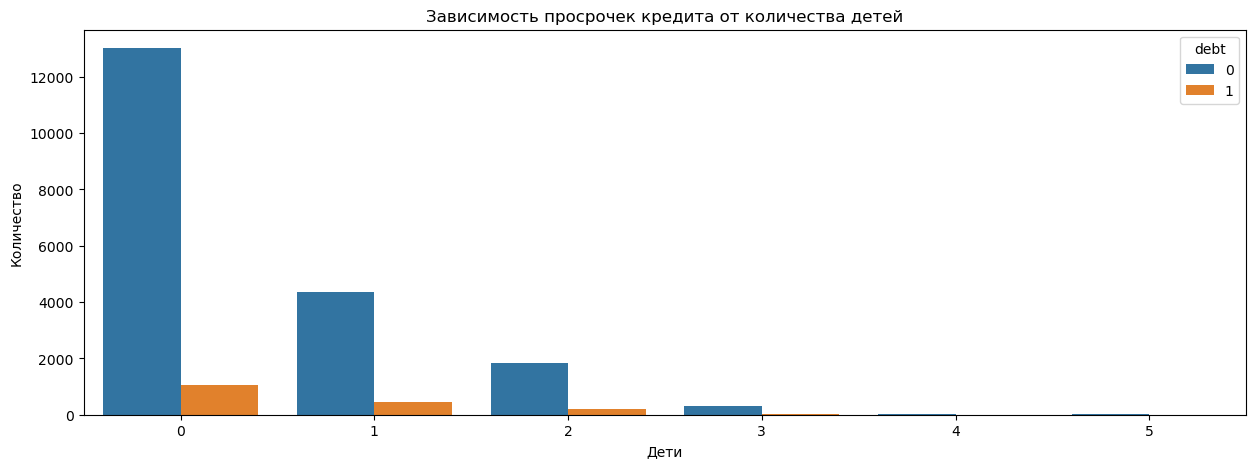

In [31]:
bar_plot(data, 'children', 
         title='Зависимость просрочек кредита от количества детей',
         xlabel='Дети',
         ylabel='Количество'
        )

In [32]:
pivot_table_calc(data, 'children')

,Всего кредитополучателей,Всего должников,Доля должников
children,,,
0,14076,1058,7.52%
1,4801,440,9.16%
2,2041,193,9.46%
3,328,27,8.23%
4,41,4,9.76%
5,9,0,0.00%


**Создадим новую переменную - `has_children`**

In [33]:
data['has_children'] = data.children.apply(lambda x: int(x > 0))

In [34]:
pivot_table_calc(data, 'has_children')

,Всего кредитополучателей,Всего должников,Доля должников
has_children,,,
0,14076,1058,7.52%
1,7220,664,9.20%


**Вывод:**<br>
    <p>Мы можем увидеть что семьи имеющие пятеро детей, не имеют просрочек кредита, но этих наблюдений очень мало, поэтому мы не можем делать выводы относительно этих семей. В целом, по нашей выборке, семьи без детей имеют просрочек практически на 2 процента ниже, чем семьи с детьми. Поэтому мы можем выдвинуть гипотезу, что семья с детьми имеет большую вероятность просрочки кредита, чем семья без детей.</p>

#### Есть ли зависимость между семейным положением и возвратом кредита в срок?

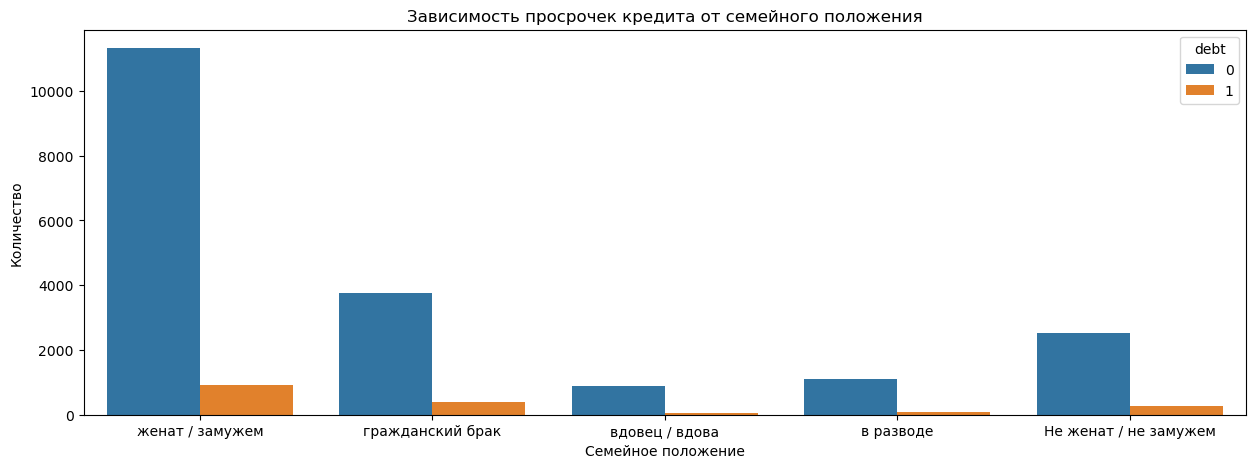

In [35]:
bar_plot(data, 'family_status', 
         title='Зависимость просрочек кредита от семейного положения',
         xlabel='Семейное положение',
         ylabel='Количество'
        )

In [36]:
pivot_table_calc(data, 'family_status')

,Всего кредитополучателей,Всего должников,Доля должников
family_status,,,
Не женат / не замужем,2782,272,9.78%
в разводе,1179,84,7.12%
вдовец / вдова,947,62,6.55%
гражданский брак,4137,383,9.26%
женат / замужем,12251,921,7.52%


**Вывод:** 
<p>Мы можем выдвинуть гипотезу о том что процент просрочек по кредитам выше у проживающих в гражданском браке и у не женатых/не замужних, чем у клиентов находящихся в разводе, вдовцов/вдов и женатых/замужем.</p>

#### Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

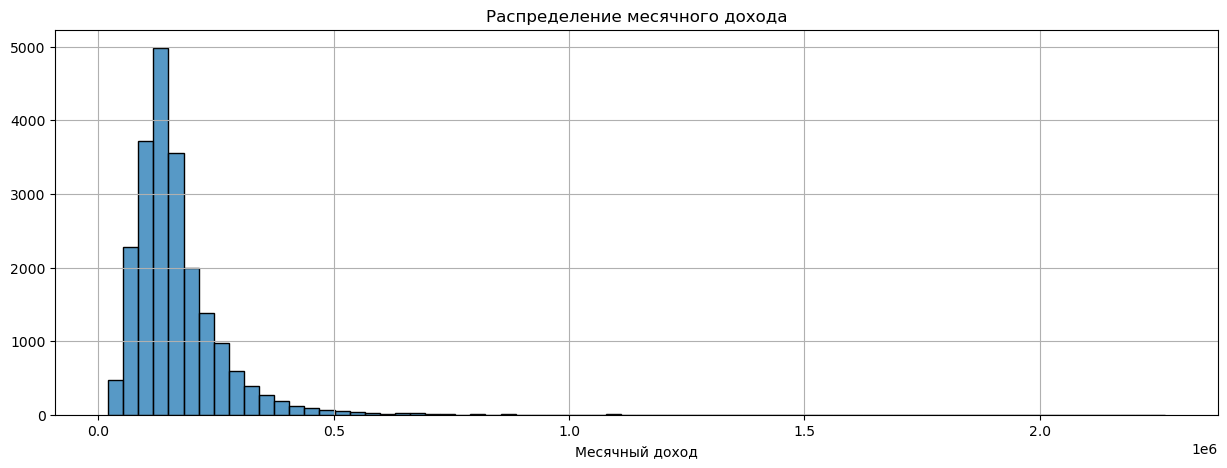

In [37]:
sns.histplot(data=data, x=data.total_income, bins=70)
plt.grid()
plt.title('Распределение месячного дохода')
plt.xlabel('Месячный доход')
plt.ylabel('')
plt.show()

**Разобьем на категории и построим сводную таблицу**

In [38]:
for i in range(3, 9):
    data['income_level'] = pd.qcut(data['total_income'], q=i, precision=0)
    pivot_table_calc(data, 'income_level')

,Всего кредитополучателей,Всего должников,Доля должников
income_level,,,
"(20666.0, 119251.0]",7099,575,8.10%
"(119251.0, 172357.0]",7252,624,8.60%
"(172357.0, 2265604.0]",6945,523,7.53%


,Всего кредитополучателей,Всего должников,Доля должников
income_level,,,
"(20666.0, 107787.0]",5324,423,7.95%
"(107787.0, 142594.0]",5465,478,8.75%
"(142594.0, 195538.0]",5183,438,8.45%
"(195538.0, 2265604.0]",5324,383,7.19%


,Всего кредитополучателей,Всего должников,Доля должников
income_level,,,
"(20666.0, 98640.0]",4260,342,8.03%
"(98640.0, 132161.0]",4259,355,8.34%
"(132161.0, 161158.0]",4260,370,8.69%
"(161158.0, 214145.0]",4258,354,8.31%
"(214145.0, 2265604.0]",4259,301,7.07%


,Всего кредитополучателей,Всего должников,Доля должников
income_level,,,
"(20666.0, 92278.0]",3550,284,8.00%
"(92278.0, 119251.0]",3549,291,8.20%
"(119251.0, 142594.0]",3690,326,8.83%
"(142594.0, 172357.0]",3562,298,8.37%
"(172357.0, 228604.0]",3395,271,7.98%
"(228604.0, 2265604.0]",3550,252,7.10%


,Всего кредитополучателей,Всего должников,Доля должников
income_level,,,
"(20666.0, 87426.0]",3043,232,7.62%
"(87426.0, 113757.0]",3042,260,8.55%
"(113757.0, 137515.0]",3042,260,8.55%
"(137515.0, 154977.0]",3042,263,8.65%
"(154977.0, 184175.0]",3042,250,8.22%
"(184175.0, 241746.0]",3042,244,8.02%
"(241746.0, 2265604.0]",3043,213,7.00%


,Всего кредитополучателей,Всего должников,Доля должников
income_level,,,
"(20666.0, 83955.0]",2662,204,7.66%
"(83955.0, 107787.0]",2662,219,8.23%
"(107787.0, 127585.0]",2662,232,8.72%
"(127585.0, 142594.0]",2803,246,8.78%
"(142594.0, 166344.0]",2521,219,8.69%
"(166344.0, 195538.0]",2662,219,8.23%
"(195538.0, 253990.0]",2662,198,7.44%
"(253990.0, 2265604.0]",2662,185,6.95%


**Вывод:**
<p>Мы можем предположить, что клиенты с маленьким доходом и клиенты большим платят исправнее , тех кто имеет средний доход</p>

#### Как разные цели кредита влияют на его возврат в срок?

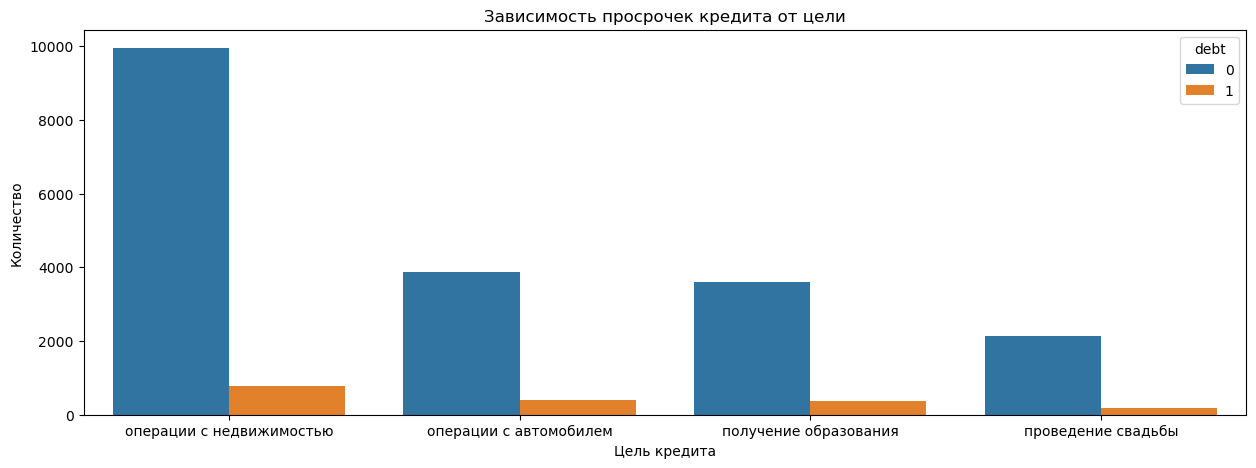

In [39]:
bar_plot(data, 'purpose_category', 
         title='Зависимость просрочек кредита от цели',
         xlabel='Цель кредита',
         ylabel='Количество'
        )

In [40]:
pivot_table_calc(data, 'purpose_category')

,Всего кредитополучателей,Всего должников,Доля должников
purpose_category,,,
операции с автомобилем,4266,396,9.28%
операции с недвижимостью,10729,776,7.23%
получение образования,3979,369,9.27%
проведение свадьбы,2322,181,7.80%


**Вывод:** 

Мы можем предположить, что кредиты на недвижимость и проведение свадьбы чаще выплачиваются вовремя, чем кредиты на авто и образование

## Общий вывод.

Мы обработали данные и установили:

* В двух переменных имеются пропущенные значения(`days_employed`, `total_income`), возможно это человеческий фактор: "Нежелание сообщать о своем доходе и опыте работы"

* В столбцах `children`, `days_employed` и `dob_years` обнаружены аномальные значения, вероятно из-за ошибки ввода данных

* В столбце `education` записаны одни и теже данные в разном регистре

* Были добавлены новые переменные: `age_cat`, `total_income_category`, `purpose_category`, `has_children` и `income_level` 

Проверили четыре гипотезы и установили:

* Клиенты с детьми имеют большую вероятность неуплаты кредита в срок

* У неженатых/незамужних клиентов и проживающих в гражданском браке вероятность просрочки платежа по кредиту выше

* Клиенты с высоким доходом с более высокой вероятностью платят по кредиту в срок

* Автокредиты и кредиты на образование имеют больше задолженностей чем по остальным категориям